# Autoencoders

Los autoencoders son redes neuronales que aprenden sobre un mismo set de datos, y pueden usarse para reducir su dimensionalidad. Esta semana seguimos trabajando con el dataset de MNIST.  Vamos a ver como aprender y cómo usar estas redes, y el ejercicio abierto es que veas la capacidad de reducir dimensionalidad para visualizar.  

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml



In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist.keys()

In [3]:
from sklearn.model_selection import train_test_split
#Tomamos el dataset y lo dividimos en X (los pixeles) e y (el número que es). 
#Recordemos que las imágenes son 28x28 = 784 pixeles
X, y = mnist['data'], mnist['target']
X_sample = X[60000:]
y_sample = y[60000:]

### Para dividir en train  - test 
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=23)


<AxesSubplot:>

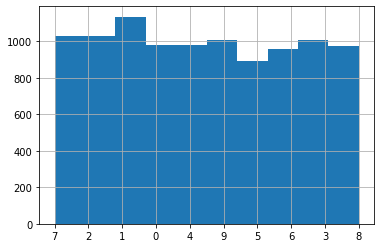

In [47]:
#Si bien los datos no están completamente balanceados, hay una buena mezcla de cada número en el dataset.
y_sample.hist()

<BarContainer object of 784 artists>

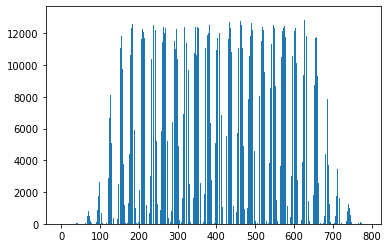

In [23]:
### Había quedado pendiente: un plot de la varianza de cada dimensión
plt.bar(np.arange(len(X_sample.columns)),X_sample.var())

Un aspecto bien importante, es que las redes autoencoders suelen trabajar mejor cuando podemos estandarizar los datos. 

In [24]:
### También vamos a estandarizar los datos en X
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
X_std = sc.fit_transform(X_sample)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [50]:
X_std[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.00005000e-02, -1.00005000e-02, -1.00005000e-02,
       -1.39737990e-02, -1.89315247e-02, -2.31843010e-02, -3.60728861e-02,
       -3.92619154e-02, -3.80269994e-02, -3.90143887e-02, -3.46046778e-02,
       -2.57765396e-02, -2.09733754e-02, -2.17809993e-02, -1.44984527e-02,
       -1.18807892e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

## Reduciendo a 5 dimensiones, autoencoder

Vamos a ver ahora como usamos un autoencoder para reducir nuestra dimensionalidad. Nuestro primer modelo es el más simple: una primera capa recibe un input de tamaño *num_dimensiones* y lo lleva a 5 neuronas. Luego esas 5 neuronas son "decodificadas" en un dataset con *num_dimensiones*.

Como esto es un autoencoder, vamos a separar conceptualmente las capas en dos. 
- una capa encoder que reduce la dimensionalidad
- una capa decoder que toma la dimensionalidad reducida y la devuelve a todas las dimensiones. 

La gracia es que podemos entrenar el autoencoder comparando los datos con los datos que fueron codificados y luego decodificados.

In [48]:
from tensorflow import keras

num_dimensiones = len(X_sample.columns)

#### Sequential es un modelo en keras que simplemente va concatenando las capas, 
#### las neuronas del final de una capa son las del principio de otra

#### keras.layers.Dense es una capa donde todas las neuronas están conectadas las unas a las otras

#### armamos el encoder: el input conectado a 5 neuronas
encoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[num_dimensiones]),
])

#### armamos el dencoder: esas 5 neuronas luego se conectan a todas las dimensiones del input 
decoder = keras.models.Sequential([
    keras.layers.Dense(num_dimensiones, input_shape=[5]),
])

#### y ahora concatenamos encoder y decoder
autoencoder = keras.models.Sequential([encoder, decoder])

#### compile lo deja listo para aprender. 
#### Para comparar el resultado del autoencoder y el dataset original 
#### usamos el clásico Mean Squared Error (a eso se le llama "loss")
#### Para entrenar usamos StochasticGradientDescent, con un alfa de 0.1 

autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(lr=0.1))

#### El entrenamiento toma los datos originales, los codifica/decodifica en vectores de la misma 
#### dimensión y los compara con los datos originales. 
#### Esto por 100 épocas, y para validar usamos el set de test. 
#### Para no perder tiempo, decidimos que debe parar si la métrica del MSE no mejora en 10 épocas. 

history = autoencoder.fit(X_train_std,X_train_std, epochs=100,validation_data=(X_test_std,X_test_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
#### Finalmente, para codificar solo llamamos al método predict de la parte de encoder. 
X_auto = encoder.predict(X_std)

Epoch 1/100
219/219 [==============================] - 7s 17ms/step - loss: 0.8509 - val_loss: 5.4501
Epoch 2/100
219/219 [==============================] - 3s 12ms/step - loss: 0.8328 - val_loss: 5.3974
Epoch 3/100
219/219 [==============================] - 2s 9ms/step - loss: 0.8030 - val_loss: 5.3484
Epoch 4/100
219/219 [==============================] - 2s 7ms/step - loss: 0.7740 - val_loss: 5.3145
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 0.7462 - val_loss: 5.2807
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 0.7174 - val_loss: 5.2538
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 0.6971 - val_loss: 5.2379
Epoch 8/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6860 - val_loss: 5.2302
Epoch 9/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6801 - val_loss: 5.2240
Epoch 10/100
219/219 [==============================] - 2s 10ms/step - loss: 0.6768 - val

219/219 [==============================] - 2s 7ms/step - loss: 0.6692 - val_loss: 5.1926
Epoch 82/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6692 - val_loss: 5.1927
Epoch 83/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6692 - val_loss: 5.1926
Epoch 84/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6692 - val_loss: 5.1929
Epoch 85/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6691 - val_loss: 5.1929
Epoch 86/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6691 - val_loss: 5.1928


In [52]:
X_auto

array([[ 1.8925257 ,  4.7239914 ,  3.5750537 ,  1.0408279 , -4.456152  ],
       [-7.8717313 ,  1.3005136 , -9.2127    , -3.6584291 ,  6.0989046 ],
       [ 0.4235208 ,  4.9710464 , -4.7106285 , -3.69764   , -4.812702  ],
       ...,
       [-0.39876637, -1.8733788 ,  3.3826168 , -0.19737819, -5.264496  ],
       [ 5.8387594 ,  0.31075642, -1.6960075 , -3.67774   , -3.1034296 ],
       [-0.67234653, -8.578598  ,  3.2054076 , -8.661794  ,  8.426323  ]],
      dtype=float32)

## Probando cuál enfoque de reducción es mejor de forma indirecta: viendo qué dataset sirve más para clasificación. 

Pero como saber si esta codificación sirve de algo? 
Una posibilidad es probarlo de forma indirecta: ejecutando algún tipo de tarea de aprendizaje sobre estos datos, y comparando los resultados. 
Aquí, comparamos con la tarea de clasificar los números de MNIST usando RandomForest. Vamos a comparar el resultado de usar RandomForest en el todo, usando PCA, y usando estos modelos de autoencoders. 

Partimos por el original: 

In [37]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

clf = tree.DecisionTreeClassifier()

np.mean(cross_val_score(clf, X_std, y_sample, cv=5, scoring='accuracy'))


0.7909999999999999

Ahora para el dataset transformado con autoencoder

In [36]:
np.mean(cross_val_score(clf, X_auto, y_sample, cv=5, scoring='accuracy'))


0.6346999999999999

Y finalmente para la decomposicion con PCA

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_std) 

In [34]:
np.mean(cross_val_score(clf, X_pca, y_sample, cv=5, scoring='accuracy'))


0.6272

### Mejores autoencoders, ¿podremos acercarnos más al acuracy del dataset original?

Un primer enfoque puede ser agregar más capas a la red neuronal. Acá abajo agregamos dos capas adicionales tanto en el encoder con el decoder: pasamos de *num_dimensiones* a 200 neuronas, luego a 50 y luego a 5, y lo mismo para decodificar. 

In [45]:
### Modelo mas profundo

encoder = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=[num_dimensiones]),
    keras.layers.Dense(50),
    keras.layers.Dense(5),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(50, input_shape=[5]),
    keras.layers.Dense(200),
    keras.layers.Dense(num_dimensiones),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(lr=0.1))

history = autoencoder.fit(X_train_std,X_train_std, epochs=100,validation_data=(X_test_std,X_test_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
X_auto_deep = encoder.predict(X_std)

c:\users\juanr\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
219/219 [==============================] - 5s 9ms/step - loss: 0.8542 - val_loss: 5.4894
Epoch 2/100
219/219 [==============================] - 2s 8ms/step - loss: 0.7949 - val_loss: 5.3705
Epoch 3/100
219/219 [==============================] - 2s 8ms/step - loss: 0.7385 - val_loss: 5.3186
Epoch 4/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6969 - val_loss: 5.2838
Epoch 5/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6789 - val_loss: 5.2655
Epoch 6/100
219/219 [==============================] - 1s 7ms/step - loss: 0.6736 - val_loss: 5.2561
Epoch 7/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6719 - val_loss: 5.2490
Epoch 8/100
219/219 [==============================] - 2s 7ms/step - loss: 0.6713 - val_loss: 5.2463
Epoch 9/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6709 - val_loss: 5.2427
Epoch 10/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6707 - val_lo

219/219 [==============================] - 2s 8ms/step - loss: 0.6693 - val_loss: 5.2009
Epoch 82/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6693 - val_loss: 5.2009
Epoch 83/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6693 - val_loss: 5.2008
Epoch 84/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6692 - val_loss: 5.2005
Epoch 85/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6692 - val_loss: 5.2005
Epoch 86/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6692 - val_loss: 5.2005
Epoch 87/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6692 - val_loss: 5.2002
Epoch 88/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6692 - val_loss: 5.2004
Epoch 89/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6692 - val_loss: 5.2001
Epoch 90/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6692 - val_loss: 

In [39]:
np.mean(cross_val_score(clf, X_auto_deep, y_sample, cv=5, scoring='accuracy'))


0.6303000000000001

## Autoencoders con activación no lineal

Un segundo enfoque, y lo más clásico en la práctica, es agregar una activación no lineal al final de cada capa. En este caso usamos la función Scaled Exponential Linear Unit (SELU). 

In [43]:
encoder = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=[num_dimensiones],activation='selu'),
    keras.layers.Dense(50,activation='selu'),
    keras.layers.Dense(5,activation='selu'),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(50, input_shape=[5],activation='selu'),
    keras.layers.Dense(200,activation='selu'),
    keras.layers.Dense(num_dimensiones,activation='selu'),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(lr=0.1))

history = autoencoder.fit(X_train_std,X_train_std, epochs=100,validation_data=(X_test_std,X_test_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
X_auto_deep_relu = encoder.predict(X_std)

c:\users\juanr\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
219/219 [==============================] - 3s 9ms/step - loss: 0.8577 - val_loss: 5.3019
Epoch 2/100
219/219 [==============================] - 2s 8ms/step - loss: 0.7759 - val_loss: 5.2559
Epoch 3/100
219/219 [==============================] - 2s 9ms/step - loss: 0.7361 - val_loss: 5.2233
Epoch 4/100
219/219 [==============================] - 2s 8ms/step - loss: 0.7107 - val_loss: 5.2045
Epoch 5/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6971 - val_loss: 5.1960
Epoch 6/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6901 - val_loss: 5.1911
Epoch 7/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6859 - val_loss: 5.1876
Epoch 8/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6830 - val_loss: 5.1855
Epoch 9/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6807 - val_loss: 5.1831
Epoch 10/100
219/219 [==============================] - 2s 8ms/step - loss: 0.6786 - val_lo

219/219 [==============================] - 2s 8ms/step - loss: 0.5203 - val_loss: 5.0030
Epoch 82/100
219/219 [==============================] - 1s 7ms/step - loss: 0.5186 - val_loss: 5.0182
Epoch 83/100
219/219 [==============================] - 2s 7ms/step - loss: 0.5167 - val_loss: 5.0057
Epoch 84/100
219/219 [==============================] - 2s 8ms/step - loss: 0.5147 - val_loss: 4.9981
Epoch 85/100
219/219 [==============================] - 2s 7ms/step - loss: 0.5135 - val_loss: 4.9977
Epoch 86/100
219/219 [==============================] - 2s 7ms/step - loss: 0.5117 - val_loss: 5.0075
Epoch 87/100
219/219 [==============================] - 2s 7ms/step - loss: 0.5100 - val_loss: 4.9844
Epoch 88/100
219/219 [==============================] - 2s 7ms/step - loss: 0.5083 - val_loss: 4.9887
Epoch 89/100
219/219 [==============================] - 2s 7ms/step - loss: 0.5074 - val_loss: 4.9771
Epoch 90/100
219/219 [==============================] - 2s 8ms/step - loss: 0.5057 - val_loss: 

In [44]:
np.mean(cross_val_score(clf, X_auto_deep_relu, y_sample, cv=5, scoring='accuracy'))


0.7063

## Ejercicio 1

Experimenta con distintos modelos que reduzcan a dos dimensiones. Visualiza y compara como lo hicimos en la tarea 3, con las reducciones con PCA y T-SNE, tomando como referencia las clases reales (los números que representan cada fila). 